In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from marked_hawkes import kernel_fct, lambda_rate, integrate_lambda, neg_log_likelihood, \
    closed_gradient

We will start with visualizing how would kernel function for an event with mark 1000 evolve, where it's parameters are $\kappa = 0.8$, $\beta = 0.6$, $c = 10$ and $\theta = 0.8$.

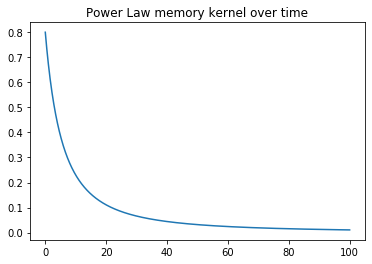

In [3]:
# initial event we want to use for simmulation (magnitude, time)
event = [1000, 0]
# series of time points we want to simmulate event for
t = np.linspace(0, 100, 1000)

# Power Law Kernel
# calling the kernelfunction to get the values
pl_values = kernel_fct(event=event, t=t)

plt.plot(t, pl_values)
plt.title("Power Law memory kernel over time");

In this section, we first read a real twitter cascade and then fit a hawkes model to it after observing first 1 hour of cacscade and then we will do the final prediction. A retweet cascade is provided in the file 'example.csv' with each row representing an event with values of the form  

** [magnitude(#user followers), time(secs)] **

In [4]:
# read the real cascade provided in the file example.csv
real_cascade = pd.read_csv('example_book.csv', names=['magnitude', 'time'], header=0)
real_cascade.index -= 1
real_cascade.head(10)

,magnitude,time
0,40989,0
1,1445,21
2,563,31
3,329,33
4,555,49
5,513,54
6,28145,58
7,100,62
8,164,82
9,491,87


In [5]:
observation_duration = 600 # seconds
history = real_cascade[real_cascade['time']<=observation_duration]

params = dict(K=0.024, 
              beta=0.5, 
              c=0.001, 
              theta=0.2)

**Event rate $\lambda(t)$ vizualisation**

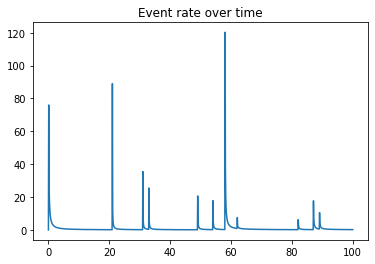

In [54]:
event_rate = lambda_rate(t, history.to_numpy(), params)

plt.plot(t, event_rate)
plt.title("Event rate over time");

Now, let's calculate the negative log-likelihood for a fixed set of parameters $(\kappa, \beta, c, \theta)$.<br>
Estimating the Hawkes process will consist in minimizing this negative log-likelihood.